In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import os
from ydata_profiling import ProfileReport

In [2]:
spark = SparkSession.builder \
    .appName("EEG_Analysis") \
    .master("local[*]") \
    .getOrCreate()

In [8]:
base_path = r"C:\Users\sachi\pyspark_tutorial\muse_pipeline\Telepathic-Navigation\muse_dataset"
body_parts = [(0,"Right_hand"), (1,"Left_hand"), (2,"Right_leg"), (3,"Left_leg")]

In [10]:
from pyspark.sql.functions import lit
"""
Load data from a folder containing multiple CSV files.
"""
def load_data(index, folder_path, part):

    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    # Initialize an empty list to store individual DataFrames
    dfs = []
    # Read each CSV file and create a DataFrame
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = spark.read.csv(file_path, header=True, inferSchema=True)
        df.shape = (df.count(), len(df.columns))
        print(f"Loaded {file} of {part} with shape {df.shape}")
        dfs.append(df)

    # Union all DataFrames
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = combined_df.union(df)
    combined_df = combined_df.withColumn("label", lit(index))
    return combined_df

# Load data for each body part
data_dict = {}
for index, part in body_parts:
    folder_path = os.path.join(base_path, part)
    data_dict[part] = load_data(index, folder_path, part)

Loaded museMonitor_2024-09-29--18-14-34_3009748603187156204.csv of Right_hand with shape (3457, 39)
Loaded museMonitor_2024-09-29--18-14-51_8074455725607840519.csv of Right_hand with shape (925, 39)
Loaded museMonitor_2024-09-29--18-15-17_4011457930878664152.csv of Right_hand with shape (1836, 39)
Loaded museMonitor_2024-09-29--18-15-27_9006091091094751811.csv of Right_hand with shape (1621, 39)
Loaded museMonitor_2024-09-29--18-15-36_1697551695837866564.csv of Right_hand with shape (1932, 39)
Loaded museMonitor_2024-09-29--18-15-47_8058529452306366508.csv of Right_hand with shape (2415, 39)
Loaded museMonitor_2024-09-29--18-15-59_1072459516511588267.csv of Right_hand with shape (2005, 39)
Loaded museMonitor_2024-09-29--18-16-10_8893711611270760972.csv of Right_hand with shape (2508, 39)
Loaded museMonitor_2024-09-29--18-16-24_3789974179702985029.csv of Right_hand with shape (2821, 39)
Loaded museMonitor_2024-09-29--18-16-38_4790734133431057690.csv of Right_hand with shape (2630, 39)
L

In [8]:
#  Select relevant columns and drop NA values
columns_to_analyze = [
    "Delta_TP9", "Delta_AF7", "Delta_AF8", "Delta_TP10",
    "Theta_TP9", "Theta_AF7", "Theta_AF8", "Theta_TP10",
    "Alpha_TP9", "Alpha_AF7", "Alpha_AF8", "Alpha_TP10",
    "Beta_TP9", "Beta_AF7", "Beta_AF8", "Beta_TP10",
    "Gamma_TP9", "Gamma_AF7", "Gamma_AF8", "Gamma_TP10", "label"
]

In [13]:
data_dict["Right_leg"].show(5)

+--------------------+---------+---------+---------+----------+---------+---------+---------+----------+---------+---------+---------+----------+--------+---------+---------+---------+----------+---------+---------+----------+-------+-------+---------+---------+---------+-----------------+---------------+---------------+--------------+-----------------+----------------+----------+-------+-------+-------+--------+-------+--------+-----+
|           TimeStamp|Delta_TP9|Delta_AF7|Delta_AF8|Delta_TP10|Theta_TP9|Theta_AF7|Theta_AF8|Theta_TP10|Alpha_TP9|Alpha_AF7|Alpha_AF8|Alpha_TP10|Beta_TP9| Beta_AF7| Beta_AF8|Beta_TP10| Gamma_TP9|Gamma_AF7|Gamma_AF8|Gamma_TP10|RAW_TP9|RAW_AF7|  RAW_AF8| RAW_TP10|AUX_RIGHT|  Accelerometer_X|Accelerometer_Y|Accelerometer_Z|        Gyro_X|           Gyro_Y|          Gyro_Z|HeadBandOn|HSI_TP9|HSI_AF7|HSI_AF8|HSI_TP10|Battery|Elements|label|
+--------------------+---------+---------+---------+----------+---------+---------+---------+----------+---------+------

In [ ]:
'''
This code cell generates Profile Reports for each particular dataset.
'''
body_parts = ["Right_hand", "Left_hand", "Right_leg", "Left_leg"]

right_hand_df = data_dict["Right_hand"].select(columns_to_analyze).dropna().toPandas()
left_hand_df = data_dict["Left_hand"].select(columns_to_analyze).dropna().toPandas()
right_leg_df = data_dict["Right_leg"].select(columns_to_analyze).dropna().toPandas()
left_leg_df = data_dict["Left_leg"].select(columns_to_analyze).dropna().toPandas()

# Right_hand Profiling Report
right_hand_profile = ProfileReport(right_hand_df, title='Right Hand Pandas Profiling Report', explorative=True)
right_hand_profile.to_file(os.path.join(base_path, "right_hand_profile.html"))

# Left_hand Profiling Report
left_hand_profile = ProfileReport(left_hand_df, title='Left Hand Pandas Profiling Report', explorative=True)
left_hand_profile.to_file(os.path.join(base_path, "left_hand_profile.html"))

# Right_leg Profiling Report
right_leg_profile = ProfileReport(right_leg_df, title='Right Leg Pandas Profiling Report', explorative=True)
right_leg_profile.to_file(os.path.join(base_path, "right_leg_profile.html"))

# Left_leg Profiling Report
left_leg_profile = ProfileReport(left_leg_df, title='Left Leg Pandas Profiling Report', explorative=True)
left_leg_profile.to_file(os.path.join(base_path, "left_leg_profile.html"))


In [ ]:
'''
These code cells compare each body part data with the others.
'''
compared_profile = right_hand_profile.compare(left_hand_profile)
compared_profile.to_file(os.path.join(base_path, "right_hand_vs_left_hand.html"))

compared_profile = right_hand_profile.compare(right_leg_profile)
compared_profile.to_file(os.path.join(base_path, "right_hand_vs_right_leg.html"))

compared_profile = right_leg_profile.compare(left_leg_profile)
compared_profile.to_file(os.path.join(base_path, "right_leg_vs_left_leg.html"))

In [5]:
'''
Visualisation columns
'''
body_parts = ["Right_hand", "Left_hand", "Right_leg", "Left_leg"]

columns = ["Delta_TP9", "Delta_AF7", "Delta_AF8", "Delta_TP10"]
# columns = ["Theta_TP9", "Theta_AF7", "Theta_AF8", "Theta_TP10"]
# columns = ["Alpha_TP9", "Alpha_AF7", "Alpha_AF8", "Alpha_TP10"]
# columns = ["Beta_TP9", "Beta_AF7", "Beta_AF8", "Beta_TP10"]
# columns = ["Gamma_TP9", "Gamma_AF7", "Gamma_AF8", "Gamma_TP10"]

right_hand = data_dict["Right_hand"].select(columns).dropna().toPandas()
left_hand = data_dict["Left_hand"].select(columns).dropna().toPandas()
right_leg = data_dict["Right_leg"].select(columns).dropna().toPandas()
left_leg = data_dict["Left_leg"].select(columns).dropna().toPandas()

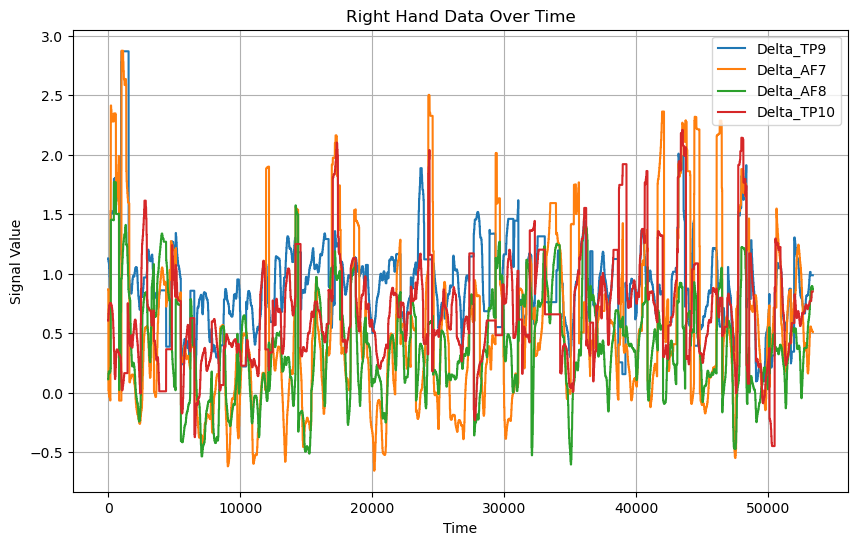

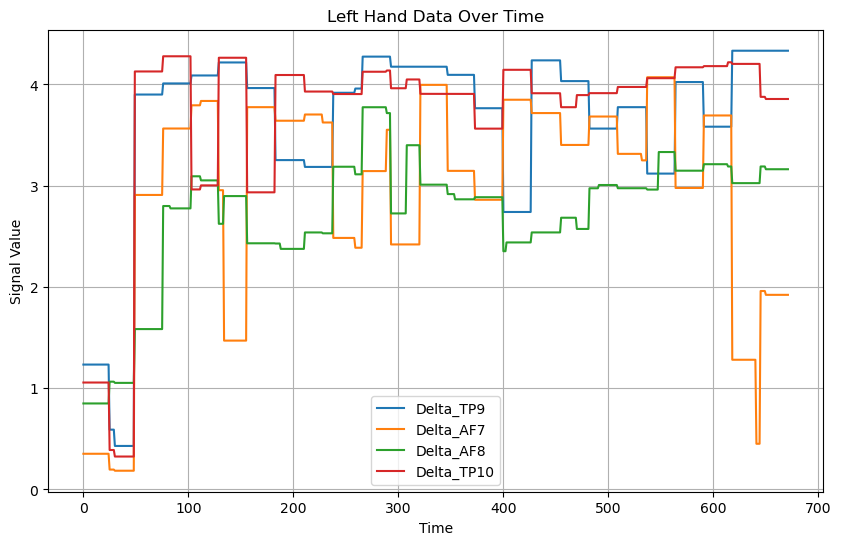

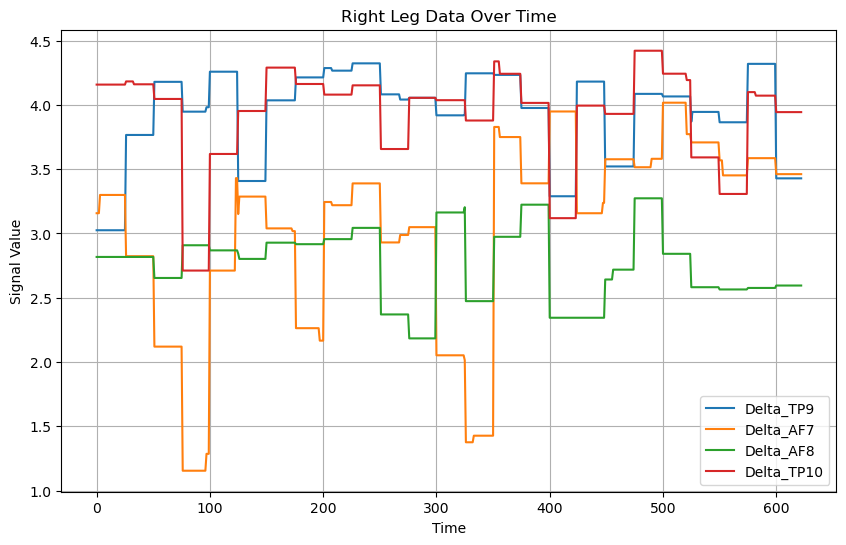

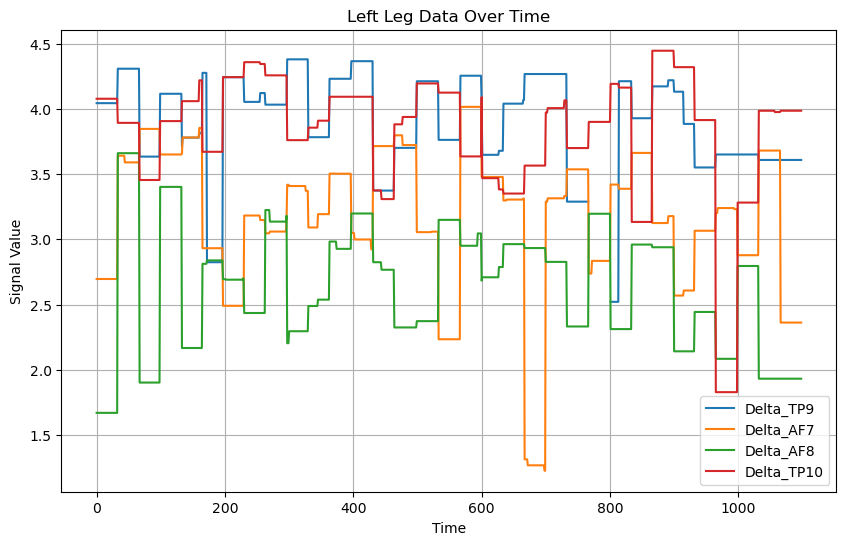

In [6]:
'''
This code cell visualises the data by plotting the Delta, Theta, Alpha, Beta, and Gamma waves for each body part.
'''
import matplotlib.pyplot as plt

# Define a function to plot body part data
def plot_body_part(body_part_data, body_part_name, columns):
    # Plot each column for the body part
    plt.figure(figsize=(10, 6))
    for col in columns:
        plt.plot(body_part_data.index, body_part_data[col], label=col)
    
    # Add title and labels
    plt.title(f'{body_part_name} Data Over Time')
    plt.xlabel('Time')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot right hand data
plot_body_part(right_hand, 'Right Hand', columns)

# Plot left hand data
plot_body_part(left_hand, 'Left Hand', columns)

# Plot right leg data
plot_body_part(right_leg, 'Right Leg', columns)

# Plot left leg data
plot_body_part(left_leg, 'Left Leg', columns)

